In [1]:
scores = '../out/ko_scores.txt'
dev = '../out/deviating.tsv'
sgd = '../out/SGD_features.tab'

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib_venn import venn2, venn3

sns.set_style('white')

plt.rc('font', size=12)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
import random
import itertools
import numpy as np
import pandas as pd

In [4]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

In [5]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
    print(s, len(gs))
print('')
print('total', len(genes))
genes = sorted(genes)
p = m.reset_index().set_index('gene').loc[genes].groupby('condition').sum()['phenotype']
pgenes = m.loc[(slice(None), genes),].groupby('gene')['phenotype'].max()
pgenes = set(pgenes[pgenes == True].index)

YPS 4093
S288C 4889
Y55 4190
UWOP 4014

total 3786


In [6]:
m = pd.read_table(dev)

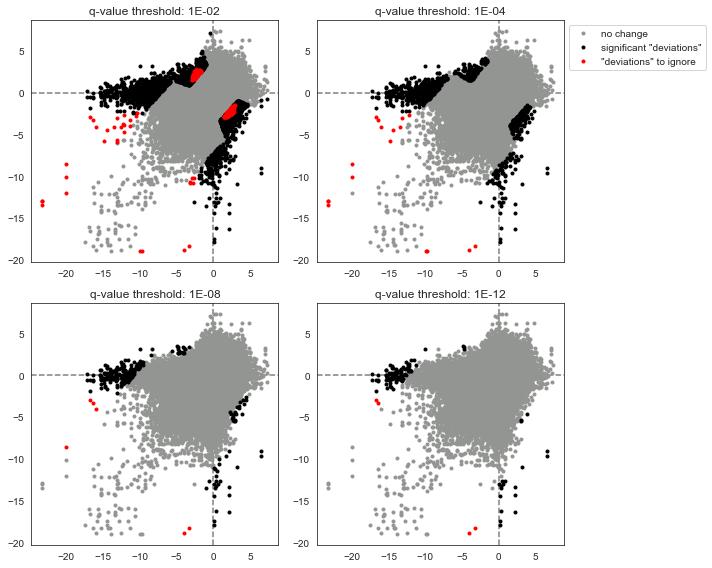

In [7]:
plt.figure(figsize=(10, 8))

for idx, pval in enumerate([1E-2, 1E-4, 1E-8, 1E-12]):
    plt.subplot(2, 2, idx+1)

    plt.axhline(0,
                color='grey',
                ls='dashed')
    plt.axvline(0,
                color='grey',
                ls='dashed')

    d = m[m['qval'] < pval].index

    plt.plot(m.loc[m.index.difference(d)]['scores1'],
             m.loc[m.index.difference(d)]['scores2'],
             '.',
             color=sns.xkcd_rgb['grey'],
             label='no change')

    e = m[(m['qval'] < pval) &
          ((m['phenotype1']) | (m['phenotype2']))].index
    f = m[(m['qval'] < pval) &
          ((m['phenotype1']) & (m['phenotype2'])) &
          (np.sign(m['scores1']) != np.sign(m['scores2']))].index
    g = m[(m['qval'] < pval) &
          ((m['phenotype1']) & (m['phenotype2'])) &
          (np.sign(m['scores1']) == np.sign(m['scores2']))].index

    d = d.difference(e).difference(f).difference(g)
    e = e.difference(f).difference(g)

    i = e.union(f)

    plt.plot(m.loc[i]['scores1'],
             m.loc[i]['scores2'],
             'k.',
             label='significant "deviations"')

    h = g.union(d)

    plt.plot(m.loc[h]['scores1'],
             m.loc[h]['scores2'],
             'r.',
             label='"deviations" to ignore')
    
    plt.title('q-value threshold: %0.E' % pval)

    if idx == 1:
        plt.legend(bbox_to_anchor=(1, 1),
                   loc='upper left',
                   frameon=True)

plt.tight_layout();

In [8]:
d = pd.read_table(dev, index_col=[4, 5, 1, 0])
d = d.loc[(slice(None), slice(None), genes),]
d = d.sort_index()

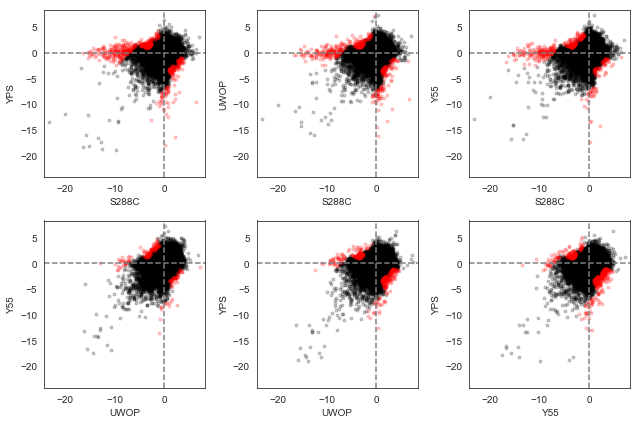

In [9]:
plt.figure(figsize=(9, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[0])

i = 1
for s1, s2 in ss:
    plt.subplot(2, 3, i)
    
    x = d.loc[(s1, s2),]
    plt.plot(x[x['qvalue'] >= 1E-2]['scores1'],
             x[x['qvalue'] >= 1E-2]['scores2'],
             'k.',
             alpha=0.2)
    plt.plot(x[x['qvalue'] < 1E-2]['scores1'],
             x[x['qvalue'] < 1E-2]['scores2'],
             'r.',
             alpha=0.2)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    i += 1

plt.tight_layout();

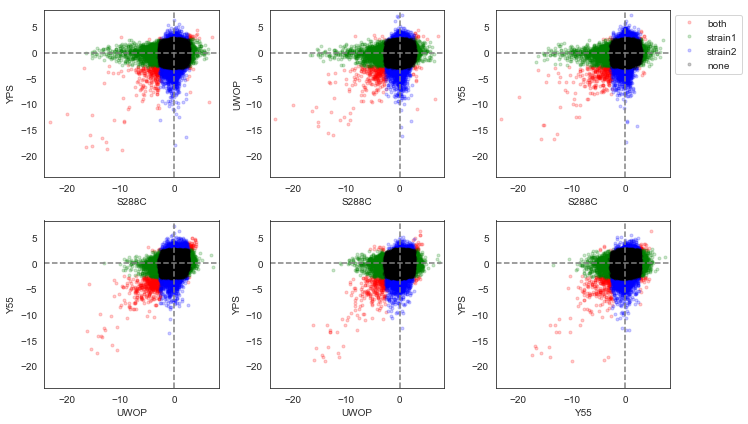

In [10]:
plt.figure(figsize=(10.5, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[0])

i = 1
for s1, s2 in ss:
    plt.subplot(2, 3, i)
    
    label1 = 'both'
    label2 = 'strain1'
    label3 = 'strain2'
    label4 = 'none'
    
    x = d.loc[(s1, s2),]
    plt.plot(x[x['phenotype1'] & x['phenotype2']]['scores1'],
             x[x['phenotype1'] & x['phenotype2']]['scores2'],
             'r.',
             alpha=0.2,
             label=label1)
    plt.plot(x[x['phenotype1'] & np.invert(x['phenotype2'])]['scores1'],
             x[x['phenotype1'] & np.invert(x['phenotype2'])]['scores2'],
             'g.',
             alpha=0.2,
             label=label2)
    plt.plot(x[x['phenotype2'] & np.invert(x['phenotype1'])]['scores1'],
             x[x['phenotype2'] & np.invert(x['phenotype1'])]['scores2'],
             'b.',
             alpha=0.2,
             label=label3)
    plt.plot(x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores1'],
             x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores2'],
             'k.',
             alpha=0.2,
             label=label4)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    if i ==3:
        lg = plt.legend(loc='upper left',
                        bbox_to_anchor=(1, 1),
                        frameon=True)
        for x in lg.legendHandles:
            lg.set_alpha(1)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    i += 1

plt.tight_layout();

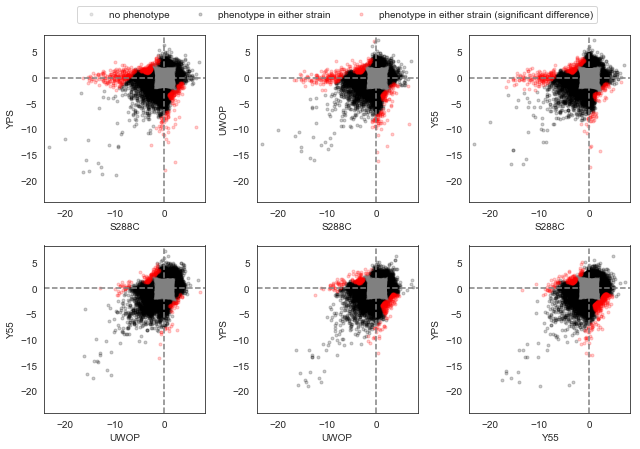

In [11]:
plt.figure(figsize=(9, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[0])

i = 1
for s1, s2 in ss:
    if i == 2:
        ax = plt.subplot(2, 3, i)
    else:
        plt.subplot(2, 3, i)
    
    label = 'no phenotype'
    label1 = 'phenotype in either strain'
    label2 = 'phenotype in either strain (significant difference)'
    
    x = d.loc[(s1, s2),]
    plt.plot(x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores1'],
             x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores2'],
             '.',
             color='grey',
             alpha=0.2,
             label=label)
    plt.plot(x[(x['qvalue'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores1'],
             x[(x['qvalue'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores2'],
             'k.',
             alpha=0.2,
             label=label1)
    plt.plot(x[(x['qvalue'] < 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores1'],
             x[(x['qvalue'] < 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores2'],
             'r.',
             alpha=0.2,
             label=label2)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    i += 1

plt.tight_layout()
lg = ax.legend(loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               frameon=True,
               ncol=3)
for x in lg.legendHandles:
    lg.set_alpha(1);

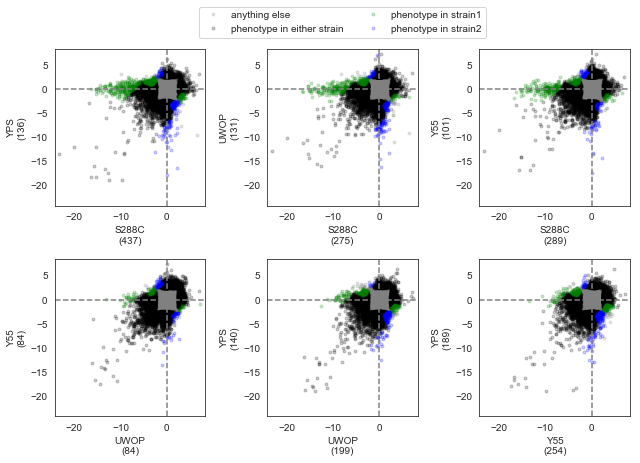

In [12]:
plt.figure(figsize=(9, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[0])

i = 1
for s1, s2 in ss:
    if i == 2:
        ax = plt.subplot(2, 3, i)
    else:
        plt.subplot(2, 3, i)
    
    label = 'anything else'
    label1 = 'phenotype in either strain'
    label2 = 'phenotype in strain1'
    label3 = 'phenotype in strain2'
    
    x = d.loc[(s1, s2),]
    idx1 = set(x[(x['qvalue'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])].index)
    idx2 = set(x[(x['qvalue'] < 1E-2) & (x['phenotype1'] & np.invert(x['phenotype2']))].index)
    idx3 = set(x[(x['qvalue'] < 1E-2) & (x['phenotype2'] & np.invert(x['phenotype1']))].index)
    idx = sorted(set(x.index) - idx1 - idx2 - idx3)
    plt.plot(x.loc[idx]['scores1'],
             x.loc[idx]['scores2'],
             '.',
             color='grey',
             alpha=0.2,
             label=label)
    plt.plot(x[(x['qvalue'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores1'],
             x[(x['qvalue'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores2'],
             'k.',
             alpha=0.2,
             label=label1)
    plt.plot(x[(x['qvalue'] < 1E-2) & (x['phenotype1'] & np.invert(x['phenotype2']))]['scores1'],
             x[(x['qvalue'] < 1E-2) & (x['phenotype1'] & np.invert(x['phenotype2']))]['scores2'],
             'g.',
             alpha=0.2,
             label=label2)
    plt.plot(x[(x['qvalue'] < 1E-2) & (x['phenotype2'] & np.invert(x['phenotype1']))]['scores1'],
             x[(x['qvalue'] < 1E-2) & (x['phenotype2'] & np.invert(x['phenotype1']))]['scores2'],
             'b.',
             alpha=0.2,
             label=label3)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel('%s\n(%d)' % (s1, len(idx2)))
    plt.ylabel('%s\n(%d)' % (s2, len(idx3)))
        
    i += 1

plt.tight_layout()

lg = ax.legend(loc='upper center',
               bbox_to_anchor=(0.5, 1.3),
               frameon=True,
               ncol=2)
for x in lg.legendHandles:
    lg.set_alpha(1);

In [13]:
res = []
for s1, s2 in sorted({tuple(x[:2])
                      for x in d.index},
                     key=lambda x: x[0]):
    v = d[d['phenotype1'] | d['phenotype2']].loc[(s1, s2),]
    idx = set(v.index)
    idx1 = set(v[v['phenotype1'] & np.invert(v['phenotype2']) & (v['qvalue'] < 1E-2)].index)
    idx2 = set(v[v['phenotype2'] & np.invert(v['phenotype1']) & (v['qvalue'] < 1E-2)].index)
    # switches
    idx3 = set(v[v['phenotype1'] & v['phenotype2'] & (v['qvalue'] < 1E-2)].index)
    idx = idx - idx1 - idx2 - idx3
    idx1 = idx1 - idx3
    idx2 = idx2 - idx3
    res.append(([len(idx1), len(idx), len(idx2), len(idx3)], [s1, s2]))

In [14]:
strains = {y
           for x in d.index
           for y in x[:2]}
palette = sns.color_palette('Set1', len(strains))
cstrains = {x: c
            for x,c in zip(strains, palette)}

/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


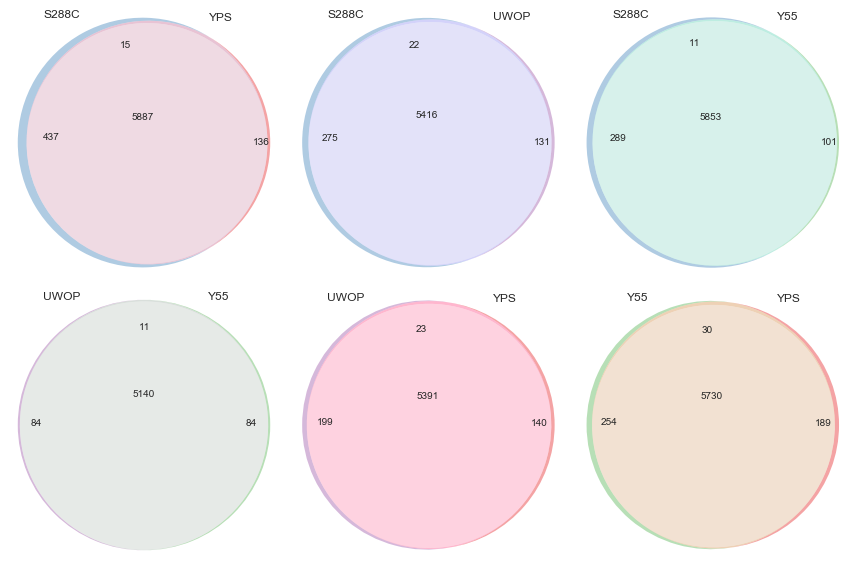

In [15]:
plt.figure(figsize=(12, 8))

for i, t in enumerate(res):
    plt.subplot(2, 3, i+1)
    
    (vs1, vs, vs2, vs3), (s1, s2) = t
    
    _ = venn3([vs1, vs2, vs3,
               0, 0, 0, vs],
              [s1, s2, ''],
              normalize_to=10,
              set_colors=[cstrains[s1],
                          cstrains[s2],
                          'w'])
plt.tight_layout()

In [16]:
res = []
for s1, s2 in sorted({tuple(x[:2])
                      for x in d.index},
                     key=lambda x: x[1]):
    y = d.loc[(s1, s2), ]
    
    p1 = y[y['phenotype1']].shape[0]
    p2 = y[y['phenotype2']].shape[0]

    x = y[(y['phenotype1']) | (y['phenotype2'])]
    
    sw = x[(x['phenotype1']) & (x['phenotype2']) & (np.sign(x['scores1']) != np.sign(x['scores2'])) & (x['qval'] < 0.01)].shape[0]
    
    e1 = x[(x['phenotype1']) & (x['qvalue'] < 0.01)].shape[0]
    e2 = x[(x['phenotype2']) & (x['qvalue'] < 0.01)].shape[0]
    
    sh1 = x[(x['phenotype1']) & (x['qvalue'] >= 0.01)].shape[0]
    sh2 = x[(x['phenotype2']) & (x['qvalue'] >= 0.01)].shape[0]
    
    res.append((s1, s2, y.shape[0], p1, sh1, e1, sw))
    res.append((s2, s1, y.shape[0], p2, sh2, e2, sw))

r = pd.DataFrame(res,
                 columns=['strain', 'other',
                          'scores',
                          'phenotypes',
                          'shared',
                          'exclusive',
                          'switches'])
r['pshared'] = r['shared'] / r['phenotypes']
r['pexclusive'] = r['exclusive'] / r['phenotypes']
r['pswitches'] = r['switches'] / r['phenotypes']

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


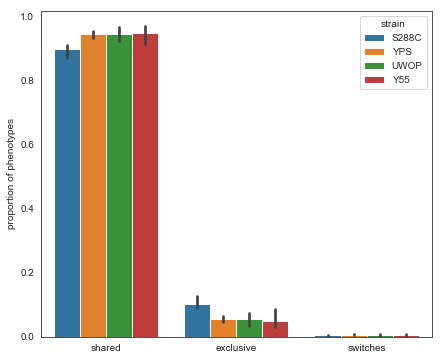

In [17]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['pshared',
                          'pexclusive',
                          'pswitches'])]

plt.figure(figsize=(7, 6))

sns.barplot(x='variable',
            y='value',
            hue='strain',
            data=p,
            hue_order=r.groupby('strain').mean().sort_values('pshared').index)

plt.ylabel('proportion of phenotypes')
plt.xlabel('')

plt.xticks(range(3),
           ['shared', 'exclusive', 'switches']);

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


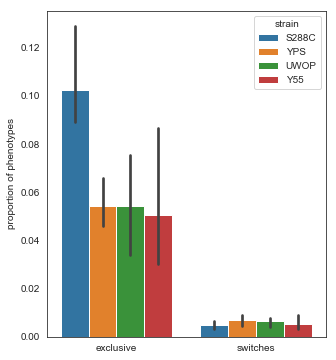

In [18]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['pexclusive',
                          'pswitches'])]

plt.figure(figsize=(5, 6))

sns.barplot(x='variable',
            y='value',
            hue='strain',
            data=p,
            hue_order=r.groupby('strain').mean().sort_values('pshared').index)

plt.ylabel('proportion of phenotypes')
plt.xlabel('')

plt.xticks(range(2),
           ['exclusive', 'switches']);

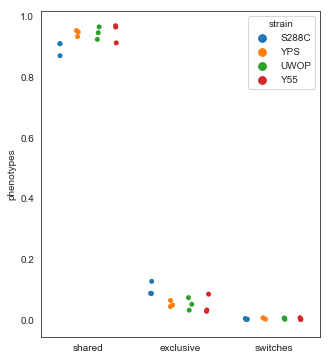

In [19]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['pshared',
                          'pexclusive',
                          'pswitches'])]

plt.figure(figsize=(5, 6))

sns.stripplot(x='variable',
              y='value',
              hue='strain',
              data=p,
              hue_order=r.groupby('strain').mean().sort_values('pshared').index,
              dodge=True)

plt.ylabel('phenotypes')
plt.xlabel('')

plt.xticks(range(3),
           ['shared', 'exclusive', 'switches']);

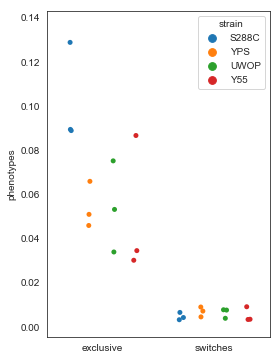

In [20]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['pexclusive',
                          'pswitches'])]

plt.figure(figsize=(4, 6))

sns.stripplot(x='variable',
              y='value',
              hue='strain',
              data=p,
              hue_order=r.groupby('strain').mean().sort_values('pshared').index,
              dodge=True)

plt.ylabel('phenotypes')
plt.xlabel('')

plt.xticks(range(2),
           ['exclusive', 'switches']);

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


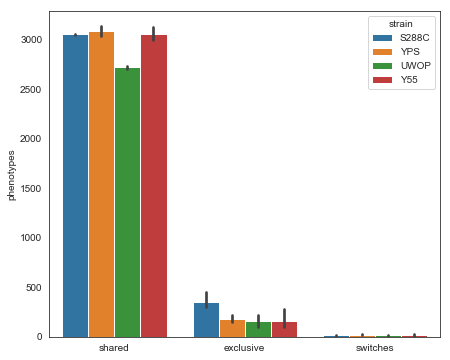

In [21]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['shared',
                          'exclusive',
                          'switches'])]

plt.figure(figsize=(7, 6))

sns.barplot(x='variable',
            y='value',
            hue='strain',
            data=p,
            hue_order=r.groupby('strain').mean().sort_values('pshared').index)

plt.ylabel('phenotypes')
plt.xlabel('')

plt.xticks(range(3),
           ['shared', 'exclusive', 'switches']);

In [22]:
res = []
for s1, s2, c in sorted({tuple(list(x[:2]) + [x[-1]])
                         for x in d.index},
                       key=lambda x: x[1]):
    y = d.loc[(s1, s2, slice(None), c), ]
    
    p1 = y[y['phenotype1']].shape[0]
    p2 = y[y['phenotype2']].shape[0]

    x = y[(y['phenotype1']) | (y['phenotype2'])]
    
    sw = x[(x['phenotype1']) & (x['phenotype2']) & (np.sign(x['scores1']) != np.sign(x['scores2'])) & (x['qval'] < 0.01)].shape[0]
    
    e1 = x[(x['phenotype1']) & (x['qvalue'] < 0.01)].shape[0]
    e2 = x[(x['phenotype2']) & (x['qvalue'] < 0.01)].shape[0]
    
    sh1 = x[(x['phenotype1']) & (x['qvalue'] >= 0.01)].shape[0]
    sh2 = x[(x['phenotype2']) & (x['qvalue'] >= 0.01)].shape[0]
    
    res.append((s1, s2, c, y.shape[0], p1, sh1, e1, sw))
    res.append((s2, s1, c, y.shape[0], p2, sh2, e2, sw))

r = pd.DataFrame(res,
                 columns=['strain', 'other',
                          'condition',
                          'scores',
                          'phenotypes',
                          'shared',
                          'exclusive',
                          'switches'])
r['pshared'] = r['shared'] / r['phenotypes']
r['pexclusive'] = r['exclusive'] / r['phenotypes']
r['pswitches'] = r['switches'] / r['phenotypes']

In [23]:
p = r.set_index(['condition', 'strain']).stack()

p = p.to_frame().reset_index()
p.columns = ['condition',
             'strain',
             'variable',
             'value']
p = p[p['variable'].isin(['pshared',
                          'pexclusive',
                          'pswitches'])]

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


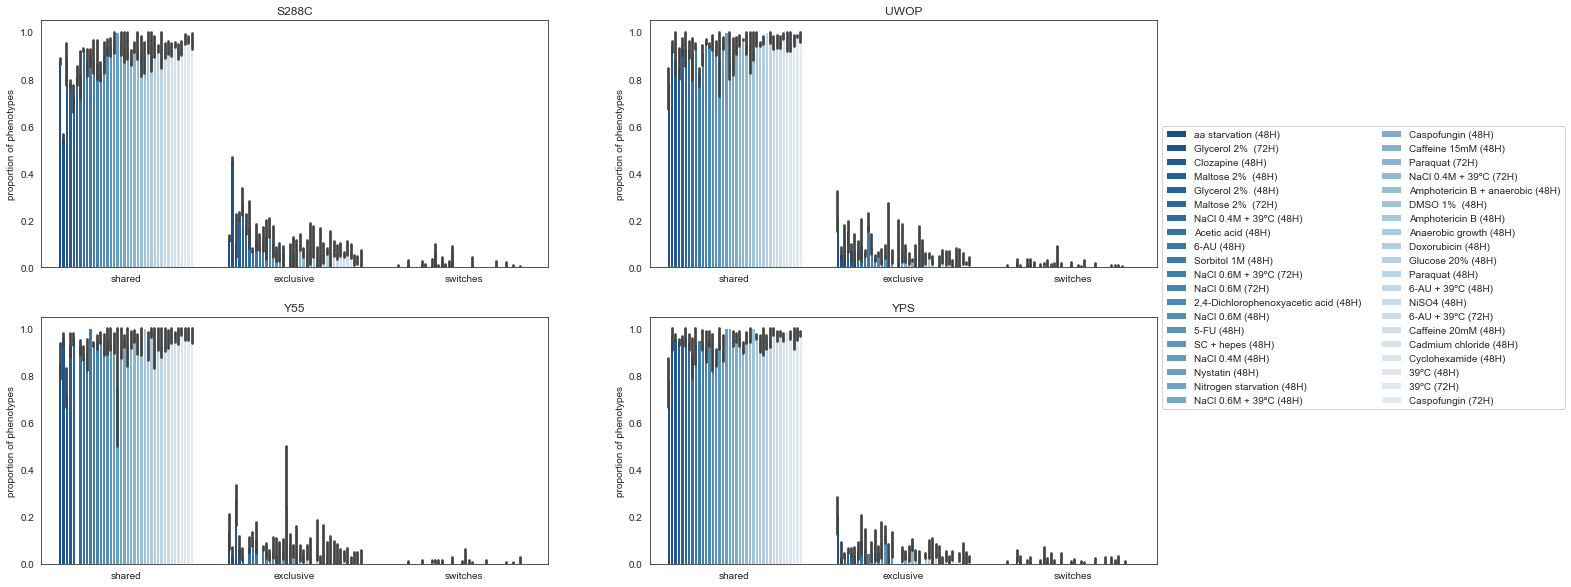

In [24]:
plt.figure(figsize=(20, 10))

for i, strain in enumerate(sorted(r['strain'].unique())):
    plt.subplot(2, 2, i+1)
    
    sns.barplot(x='variable',
                y='value',
                hue='condition',
                data=p[p['strain'] == strain],
                hue_order=r.groupby('condition').mean().sort_values('pshared').index,
                palette=sns.color_palette('Blues_r', len(r['condition'].unique())+10)[5:])

    plt.ylabel('proportion of phenotypes')
    plt.xlabel('')

    plt.xticks(range(3),
               ['shared', 'exclusive', 'switches'])

    if i == 1:
        plt.legend(bbox_to_anchor=(1, 0),
                   loc='center left',
                   frameon=True,
                   ncol=2)
    else:
        ax = plt.gca()
        ax.legend_ = None
    
    plt.title(strain)

In [25]:
p = r.set_index(['condition', 'strain']).stack()

p = p.to_frame().reset_index()
p.columns = ['condition',
             'strain',
             'variable',
             'value']
p = p[p['variable'].isin(['pexclusive',
                          'pswitches'])]

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


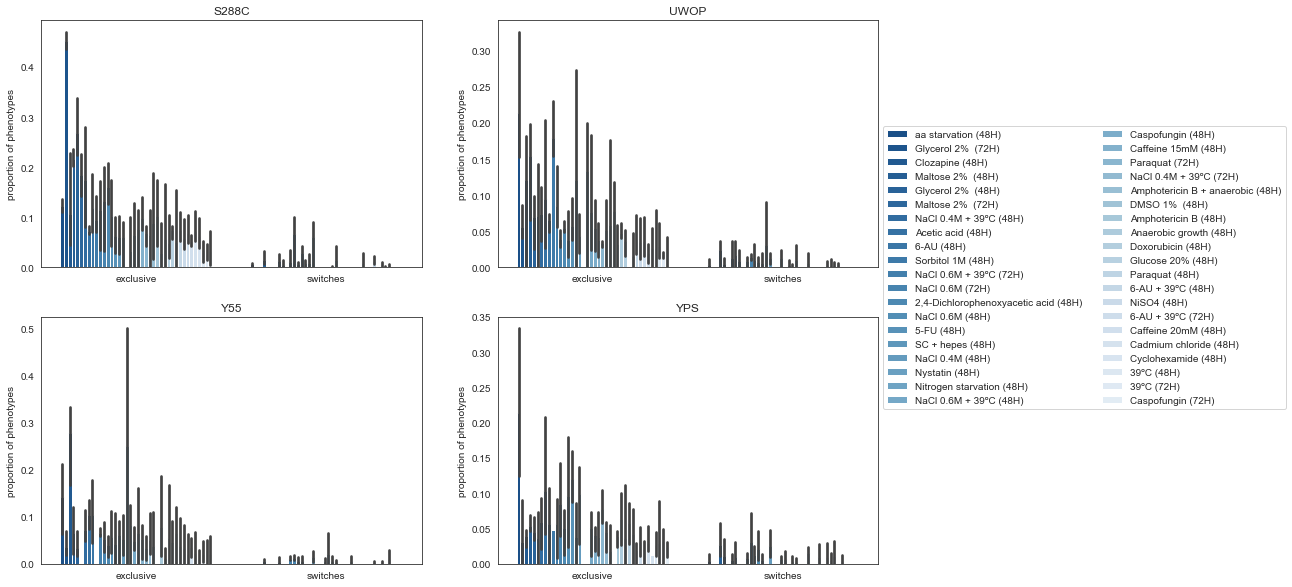

In [26]:
plt.figure(figsize=(15, 10))

for i, strain in enumerate(sorted(r['strain'].unique())):
    plt.subplot(2, 2, i+1)
    
    sns.barplot(x='variable',
                y='value',
                hue='condition',
                data=p[p['strain'] == strain],
                hue_order=r.groupby('condition').mean().sort_values('pexclusive',
                                                                    ascending=False).index,
                palette=sns.color_palette('Blues_r', len(r['condition'].unique())+10)[5:])

    plt.ylabel('proportion of phenotypes')
    plt.xlabel('')

    plt.xticks(range(2),
               ['exclusive', 'switches'])

    if i == 1:
        plt.legend(bbox_to_anchor=(1, 0),
                   loc='center left',
                   frameon=True,
                   ncol=2)
    else:
        ax = plt.gca()
        ax.legend_ = None
    
    plt.title(strain)

In [27]:
r = (d[d['qvalue'] < 0.01].groupby(['strain1', 'strain2', 'gene'])[
     'phenotype1'].sum() / d.groupby(['strain1', 'strain2', 'gene'])[
     'phenotype1'].sum()).dropna().reset_index().rename(
    columns={'strain1': 'strain',
             'strain2': 'other',
             'phenotype1': 'deviations'})
s = (d[d['qvalue'] < 0.01].groupby(['strain2', 'strain1', 'gene'])[
     'phenotype2'].sum() / d.groupby(['strain2', 'strain1', 'gene'])[
     'phenotype2'].sum()).dropna().reset_index().rename(
    columns={'strain2': 'strain',
             'strain1': 'other',
             'phenotype2': 'deviations'})
t = pd.concat([r, s], sort=False).set_index(['strain', 'other', 'gene'])
t = t.reindex([(x, y, g)
              for x, y, in itertools.product(strains, strains)
              if x != y
              for g in pgenes],
              fill_value=0)['deviations']

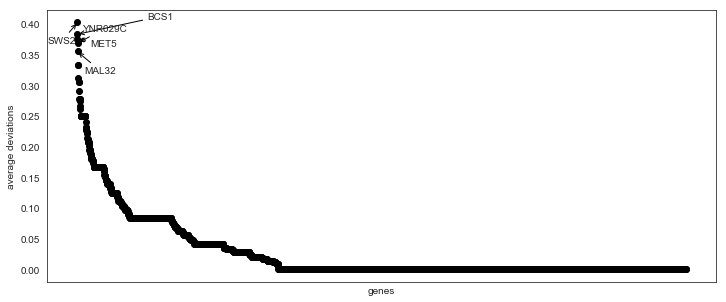

In [28]:
plt.figure(figsize=(12, 5))

x = t.groupby(['gene']).mean()

plt.plot(range(x.shape[0]),
         x.sort_values(ascending=False),
         'ko')

texts = [plt.text(i, y, gn.get(x, x),
                  ha='left',
                  va='center')
         for i, (x, y) in enumerate(x[x > 0.35].iteritems())]
adjust_text(texts,
            arrowprops=dict(arrowstyle='->',
                            color='k'),
            force_text=2)

plt.xlabel('genes')
plt.xticks([])
plt.ylabel('average deviations');

In [29]:
y = t.groupby(['strain', 'gene']).mean()

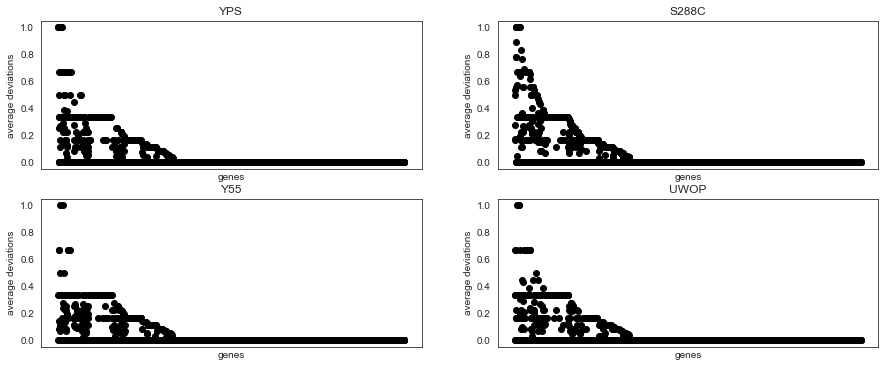

In [30]:
plt.figure(figsize=(15, 6))

for i, strain in enumerate({x[0] for x in y.index}):
    plt.subplot(2, 2, i+1)
    plt.plot(range(y.loc[strain].shape[0]),
             y.loc[strain].loc[x.sort_values(ascending=False).index],
             'ko')
    plt.xlabel('genes')
    plt.xticks([])
    plt.ylabel('average deviations')
    plt.title(strain)